In [32]:
import cv2
import numpy as np
import os, sys

project_dir = 'd:/MyFolders/project/CANN/SiamFC_CANN_v2'
sys.path.append(os.path.join(project_dir, 'siamfc_cann_v2/utils'))

from utils import img_ops, num_ops


print(np.inf)

def ori_get_dif(pre_img, img, sz, center, cann_len):
    center, sz = np.round(center), num_ops.odd(sz) # 进行取整操作; odd 是保证为奇数
    
    # 找到图中的对应区域，并裁剪下来
    ## 首先计算响应图映射回原图像后的边界：(ly, lx, ry, rx)
    response_corners = np.asarray(
                        [center[0] - (sz - 1) / 2,
                         center[1] - (sz - 1) / 2,
                         center[0] + (sz - 1) / 2 + 1,
                         center[1] + (sz - 1) / 2 + 1], dtype=np.int32)  # shape = (4, )
    
    ## 获得左上角和右下角的坐标
    h, w = img.shape[0], img.shape[1]
    top_left = response_corners[:2]
    bottom_right = response_corners[2:]
    top_left_clamped = np.clip(top_left, 0, [h, w])
    bottom_right_clamped = np.clip(bottom_right, 0, [h, w])
    
    ## 那么, 我们进行裁剪
    dif = img_ops.get_frame_difference(img[top_left_clamped[0] : bottom_right_clamped[0],
                                    top_left_clamped[1] : bottom_right_clamped[1]],
                               pre_img[top_left_clamped[0] : bottom_right_clamped[0],
                                       top_left_clamped[1] : bottom_right_clamped[1]])
    
    
    
    ## 考虑填充量
    padding = [
        top_left_clamped[0] - top_left[0],  # 上侧填充
        top_left_clamped[1] - top_left[1],  # 左侧填充
        bottom_right[0] - bottom_right_clamped[0],  # 下侧填充
        bottom_right[1] - bottom_right_clamped[1]   # 右侧填充
    ]
    
    ## 应用填充
    if np.any(padding):
        dif = cv2.copyMakeBorder(dif, padding[0], padding[2], padding[1], padding[3],
                                 borderType=cv2.BORDER_CONSTANT, value=(0, 0, 0))
    
    ## 现在, dif 理当是 (sz, sz) 的图像了
    assert dif.shape[0] == dif.shape[1] == sz
    
    movement = cv2.blur(cv2.resize(dif,(cann_len, cann_len), interpolation=cv2.INTER_CUBIC), (19, 19))
    
    return movement


def opt_get_dif(pre_img, img, sz, center, cann_len):
    center, sz = np.round(center), num_ops.odd(sz) # 进行取整操作; odd 是保证为奇数
    
    ## 首先计算响应图映射回原图像后的边界：(ly, lx, ry, rx)
    response_corners = np.asarray(
                        [center[0] - (sz - 1) / 2,
                         center[1] - (sz - 1) / 2,
                         center[0] + (sz - 1) / 2 + 1,
                         center[1] + (sz - 1) / 2 + 1], dtype=np.int32)  # shape = (4, )
    
    ## 获得左上角和右下角的坐标
    h, w = img.shape[0], img.shape[1]
    top_left = response_corners[:2]
    bottom_right = response_corners[2:]
    top_left_clamped = np.clip(top_left, 0, [h, w])
    bottom_right_clamped = np.clip(bottom_right, 0, [h, w])
    
    ## 考虑填充量
    padding = np.asarray([
        top_left_clamped[0] - top_left[0],  # 上侧填充
        top_left_clamped[1] - top_left[1],  # 左侧填充
        bottom_right[0] - bottom_right_clamped[0],  # 下侧填充
        bottom_right[1] - bottom_right_clamped[1]   # 右侧填充
    ])
    
    ## 考虑需要将裁剪下来的图片缩放到什么尺寸
    re_img_crop = 1. * (bottom_right_clamped - top_left_clamped) / sz * cann_len
    re_padding = 1. * padding / sz * cann_len
    
    ### 对 re_img_crop 和 re_padding 进行取整操作，但保证取整之后和不变
    re_img_crop_h = np.round(re_img_crop[0]).astype(np.int32)
    re_padding_top = np.round(re_padding[0]).astype(np.int32)
    if re_img_crop_h + re_padding_top > cann_len:
        re_padding_top -= 1
    re_padding_bottom = cann_len - re_img_crop_h - re_padding_top
    
    re_img_crop_w = np.round(re_img_crop[1]).astype(np.int32)
    re_padding_left = np.round(re_padding[1]).astype(np.int32)
    if re_img_crop_w + re_padding_left > cann_len:
        re_padding_left -= 1
    re_padding_right = cann_len - re_img_crop_w - re_padding_left
    
    re_img_crop_int = (re_img_crop_w, re_img_crop_h) # 注意，resize 接受的是 (w, h), ***
    re_padding_int = (re_padding_top, re_padding_left, re_padding_bottom, re_padding_right)
    
    
    ## 那么, 我们进行裁剪，而后放缩，再考虑填充
    img_crop = img[top_left_clamped[0] : bottom_right_clamped[0],
                   top_left_clamped[1] : bottom_right_clamped[1]]
    pre_img_crop = pre_img[top_left_clamped[0] : bottom_right_clamped[0],
                           top_left_clamped[1] : bottom_right_clamped[1]]
    re_img_crop = cv2.resize(img_crop, re_img_crop_int, 
                             interpolation=cv2.INTER_CUBIC)
    re_pre_img_crop = cv2.resize(pre_img_crop, re_img_crop_int,
                                 interpolation=cv2.INTER_CUBIC)
    dif = img_ops.get_frame_difference(re_img_crop, re_pre_img_crop)
    
    if np.any(re_padding_int):
        print(f'From ({dif.shape[0]}, {dif.shape[1]})')
        dif = cv2.copyMakeBorder(dif, re_padding_int[0], re_padding_int[2], re_padding_int[1], re_padding_int[3],
                                         borderType=cv2.BORDER_CONSTANT, value=(0, 0, 0))
        print(f'To ({dif.shape[0]}, {dif.shape[1]})')
        print(f'Top: {re_padding_int[0]}, Bottom: {re_padding_int[2]}, Left: {re_padding_int[1]}, Right: {re_padding_int[3]}')
    
    
    ## 现在, dif 理当是 (sz, sz) 的图像了
    print(f'({dif.shape[0]}, {dif.shape[1]}), {cann_len}')
    assert dif.shape[0] == dif.shape[1] == cann_len, print(f'({dif.shape[0]}, {dif.shape[1]}), {cann_len}')
    
    movement = cv2.blur(dif, (19, 19))
    
    return movement 


inf


From (51, 68)
To (85, 85)
Top: 21, Bottom: 13, Left: 0, Right: 17
(85, 85), 85


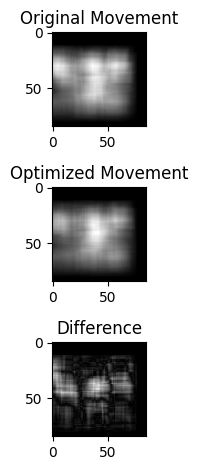

AssertionError: 

In [31]:
pre_img = cv2.imread('D:\MyFolders\project\CANN\SiamFC_CANN_v2\data\\train\GOT10K\\train\GOT-10k_Train_000001\\00000001.jpg')
img = cv2.imread('D:\MyFolders\project\CANN\SiamFC_CANN_v2\data\\train\GOT10K\\train\GOT-10k_Train_000001\\00000003.jpg')

pre_img = cv2.cvtColor(pre_img, cv2.COLOR_RGB2GRAY)
img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

h, w = img.shape[0], img.shape[1]

steps = 2

np.random.seed(1)

for _ in range(steps):
    center = np.random.rand(2) * np.asarray([h, w])
    sz = np.random.randint(1, np.max([h, w]))
    cann_len = 85
    
    ori_movement = ori_get_dif(pre_img, img, sz, center, cann_len)
    opt_movement = opt_get_dif(pre_img, img, sz, center, cann_len)
    
    import matplotlib.pyplot as plt

    fig, (ax1, ax2, ax3) = plt.subplots(3, 1)

    ax1.imshow(ori_movement, cmap='gray')
    ax1.set_title('Original Movement')

    ax2.imshow(opt_movement, cmap='gray')
    ax2.set_title('Optimized Movement')
    
    ax3.imshow(np.abs(ori_movement - opt_movement), cmap='gray')
    ax3.set_title('Difference')

    plt.tight_layout()
    plt.show()
    
    assert np.allclose(ori_movement, opt_movement)


